# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**

In [6]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility

In [7]:
def softmax(x, temp):
    """
    Given an array x and a temperature temp, compute the softmax probabilities.
    """
    x = np.array(x)
    # To improve numerical stability, subtract the max value.
    preferences = x / temp
    max_pref = np.max(preferences)
    exp_preferences = np.exp(preferences - max_pref)
    probabilities = exp_preferences / np.sum(exp_preferences)
    return probabilities

In [8]:
# ---------------------------
# SARSA Agent using softmax
# ---------------------------
class Sarsa:
    def __init__(self, env, alpha, gamma, temp):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        # Initialize the Q-table to zeros.
        self.Q = np.zeros((self.n_states, self.n_actions))

    def select_action(self, s, greedy=False):
        """
        If greedy==True, select the best action (argmax).
        Otherwise, select an action using softmax over Q-values.
        """
        if greedy:
            return np.argmax(self.Q[s])
        else:
            probs = softmax(self.Q[s], self.temp)
            return np.random.choice(self.n_actions, p=probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        """
        Standard SARSA update.
        If the episode terminates, a_prime is ignored.
        """
        if done:
            target = r
        else:
            target = r + self.gamma * self.Q[s_prime, a_prime]
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

# -------------------------------
# Expected SARSA Agent using softmax
# -------------------------------
class ExpectedSarsa:
    def __init__(self, env, alpha, gamma, temp):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.Q = np.zeros((self.n_states, self.n_actions))

    def select_action(self, s, greedy=False):
        if greedy:
            return np.argmax(self.Q[s])
        else:
            probs = softmax(self.Q[s], self.temp)
            return np.random.choice(self.n_actions, p=probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        if done:
            target = r
        else:
            # Expected value over actions in s_prime (using the softmax policy)
            action_probs = softmax(self.Q[s_prime], self.temp)
            expected_q = np.dot(action_probs, self.Q[s_prime])
            target = r + self.gamma * expected_q
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

# ------------------------------------------------------
# Bonus: Hybrid SARSA-Q Agent (a mix of SARSA and Q-learning)
# ------------------------------------------------------
class Hybrid_Sarsa_Q:
    def __init__(self, env, alpha, gamma, temp, lambda_=0.5):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.lambda_ = lambda_
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.Q = np.zeros((self.n_states, self.n_actions))

    def select_action(self, s, greedy=False):
        if greedy:
            return np.argmax(self.Q[s])
        else:
            probs = softmax(self.Q[s], self.temp)
            return np.random.choice(self.n_actions, p=probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        if done:
            target = r
        else:
            # Mix between SARSA (using a_prime) and Q-learning (using max Q)
            target = r + self.gamma * (self.lambda_ * self.Q[s_prime, a_prime] + (1 - self.lambda_) * np.max(self.Q[s_prime]))
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

# Write your experiment code below

In [10]:
env_name = 'FrozenLake-v1'
env = gym.make(env_name)
try:
    env = StepAPICompatibility(env, new_step_api=True)
except TypeError:
    env = StepAPICompatibility(env)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(4)
State space: Discrete(16)


In [12]:
# -------------------------
# Helper functions to run episodes
# -------------------------
def run_training_episode(agent, env):
    # Reset the environment; if a tuple is returned, take the first element.
    s = env.reset()
    if isinstance(s, tuple):
        s = s[0]
    total_reward = 0
    a = agent.select_action(s, greedy=False)
    
    while True:
        step_result = env.step(a)
        # Handle potential extra element (truncated) in the new Gym API.
        if len(step_result) == 5:
            s_prime, r, done, truncated, info = step_result
            done = done or truncated
        else:
            s_prime, r, done, info = step_result

        if isinstance(s_prime, tuple):
            s_prime = s_prime[0]
            
        total_reward += r
        if done:
            agent.update(s, a, r, s_prime, None, done)
            break
        a_prime = agent.select_action(s_prime, greedy=False)
        agent.update(s, a, r, s_prime, a_prime, done)
        s = s_prime
        a = a_prime
    return total_reward

def run_test_episode(agent, env):
    # Reset and extract state if necessary.
    s = env.reset()
    if isinstance(s, tuple):
        s = s[0]
    total_reward = 0
    while True:
        a = agent.select_action(s, greedy=True)
        step_result = env.step(a)
        if len(step_result) == 5:
            s, r, done, truncated, info = step_result
            done = done or truncated
        else:
            s, r, done, info = step_result

        if isinstance(s, tuple):
            s = s[0]
            
        total_reward += r
        if done:
            break
    return total_reward

def run_trial(agent_class, env, alpha, gamma, temp, num_segments=500, train_eps=10, test_eps=1):
    """
    Each trial consists of num_segments segments.
    Each segment: train_eps training episodes (agent updates Q-table) and test_eps testing episodes.
    Returns:
      training_rewards: average training reward per segment.
      testing_rewards:  average testing reward per segment.
    """
    training_rewards = []
    testing_rewards = []
    # Create a new agent for this trial.
    agent = agent_class(env, alpha, gamma, temp)
    for segment in range(num_segments):
        seg_train_rewards = []
        for _ in range(train_eps):
            r = run_training_episode(agent, env)
            seg_train_rewards.append(r)
        avg_train_reward = np.mean(seg_train_rewards)
        training_rewards.append(avg_train_reward)
        
        seg_test_rewards = []
        for _ in range(test_eps):
            r = run_test_episode(agent, env)
            seg_test_rewards.append(r)
        avg_test_reward = np.mean(seg_test_rewards)
        testing_rewards.append(avg_test_reward)
    return training_rewards, testing_rewards

In [13]:
# -------------------------
# Experiment Settings
# -------------------------
learning_rates = [0.1, 0.5, 0.9]
temperatures = [0.1, 1.0, 5.0]
gamma = 0.99
num_trials = 10
num_segments = 500           # Each trial has 500 segments.
train_eps_per_segment = 10   # 10 training episodes per segment.
test_eps_per_segment = 1     # 1 testing episode per segment.

# Store results in a nested dictionary: results[alpha][temp]
results = {}

for alpha in learning_rates:
    results[alpha] = {}
    for temp in temperatures:
        all_train = []  # Training curves for each trial.
        all_test = []   # Testing curves for each trial.
        print(f"Running trials for alpha={alpha}, temp={temp}")
        for trial in range(num_trials):
            train_rewards, test_rewards = run_trial(
                Sarsa, env, alpha, gamma, temp,
                num_segments=num_segments,
                train_eps=train_eps_per_segment,
                test_eps=test_eps_per_segment
            )
            all_train.append(train_rewards)
            all_test.append(test_rewards)
        # Average over the trials.
        avg_train = np.mean(all_train, axis=0)  # shape: (num_segments,)
        avg_test = np.mean(all_test, axis=0)
        # Final performance: average over the last 10 segments.
        final_train = np.mean(avg_train[-10:])
        final_test = np.mean(avg_test[-10:])
        results[alpha][temp] = {
            'train_curve': avg_train,
            'test_curve': avg_test,
            'final_train': final_train,
            'final_test': final_test
        }

Running trials for alpha=0.1, temp=0.1


/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/slsecret/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/slsecret/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Running trials for alpha=0.1, temp=1.0
Running trials for alpha=0.1, temp=5.0
Running trials for alpha=0.5, temp=0.1
Running trials for alpha=0.5, temp=1.0
Running trials for alpha=0.5, temp=5.0
Running trials for alpha=0.9, temp=0.1
Running trials for alpha=0.9, temp=1.0
Running trials for alpha=0.9, temp=5.0


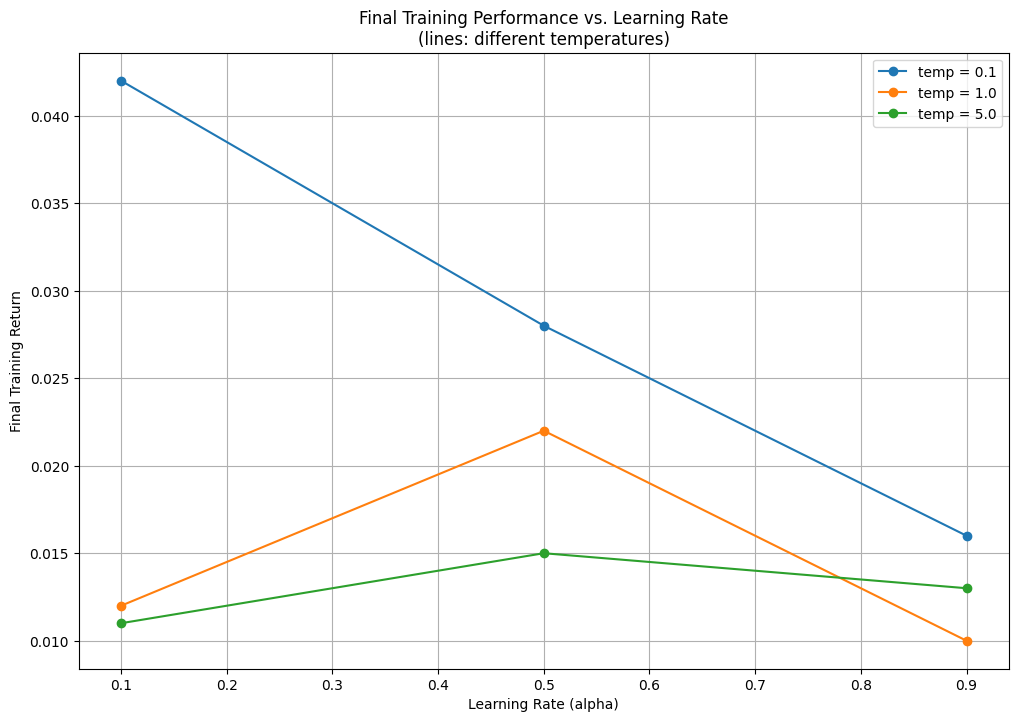

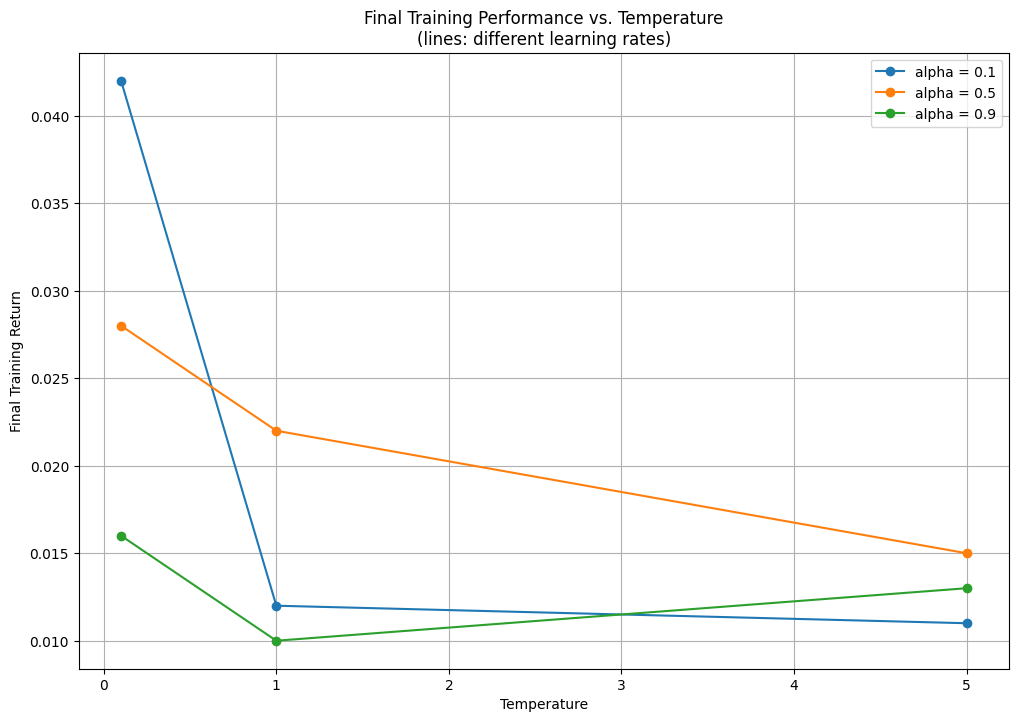

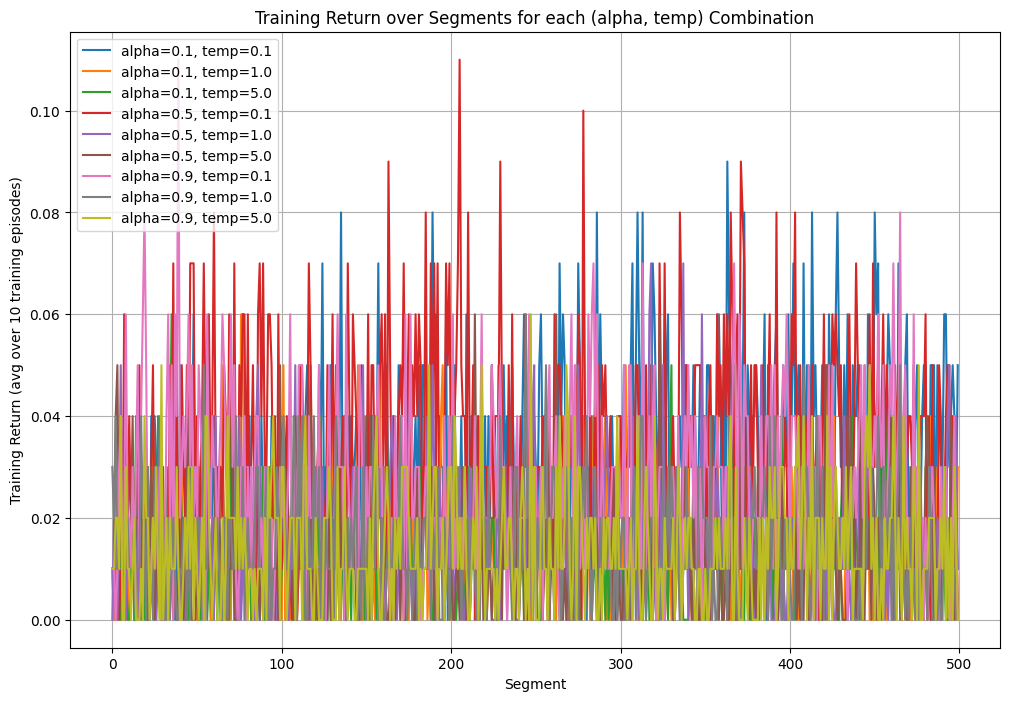

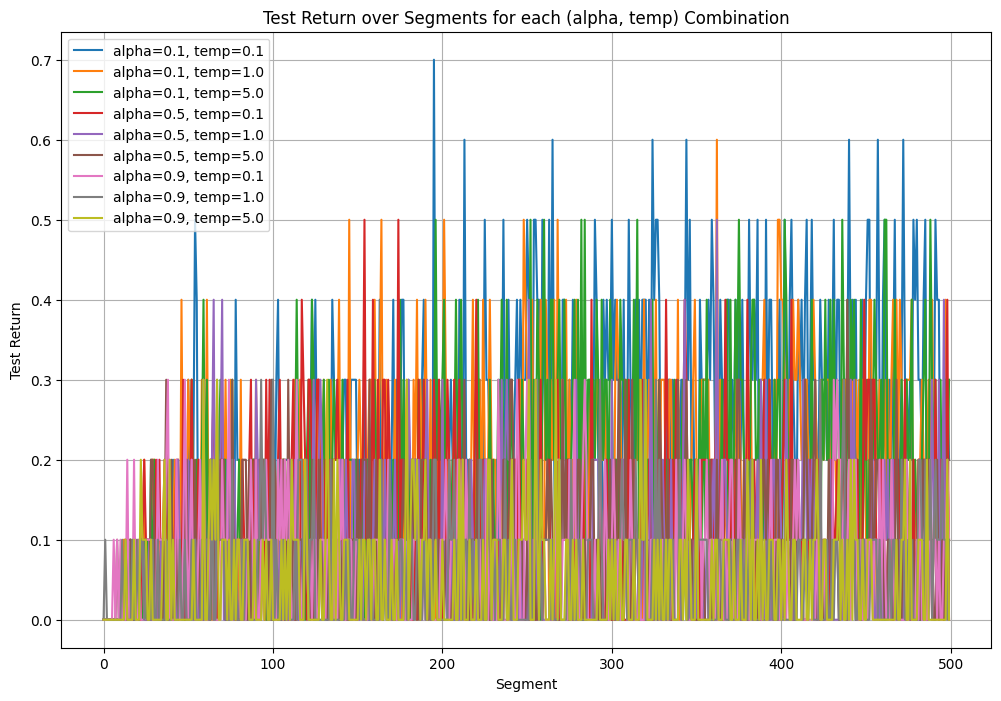

In [14]:
# -------------------------
# Plotting the Results
# -------------------------

# Graph 1: Final training performance vs. learning rate (x-axis) with lines for different temperatures.
plt.figure(figsize=(12, 8))
for temp in temperatures:
    final_trains = [results[alpha][temp]['final_train'] for alpha in learning_rates]
    plt.plot(learning_rates, final_trains, marker='o', label=f"temp = {temp}")
plt.xlabel("Learning Rate (alpha)")
plt.ylabel("Final Training Return")
plt.title("Final Training Performance vs. Learning Rate\n(lines: different temperatures)")
plt.legend()
plt.grid(True)
plt.show()

# Graph 2: Final training performance vs. temperature (x-axis) with lines for different learning rates.
plt.figure(figsize=(12, 8))
for alpha in learning_rates:
    final_trains = [results[alpha][temp]['final_train'] for temp in temperatures]
    plt.plot(temperatures, final_trains, marker='o', label=f"alpha = {alpha}")
plt.xlabel("Temperature")
plt.ylabel("Final Training Return")
plt.title("Final Training Performance vs. Temperature\n(lines: different learning rates)")
plt.legend()
plt.grid(True)
plt.show()

# Graph 3: Training reward as a function of segment index (one line per (alpha, temp) combination).
plt.figure(figsize=(12, 8))
for alpha in learning_rates:
    for temp in temperatures:
        train_curve = results[alpha][temp]['train_curve']
        plt.plot(np.arange(len(train_curve)), train_curve, label=f"alpha={alpha}, temp={temp}")
plt.xlabel("Segment")
plt.ylabel("Training Return (avg over 10 training episodes)")
plt.title("Training Return over Segments for each (alpha, temp) Combination")
plt.legend()
plt.grid(True)
plt.show()

# Graph 4: Testing performance (greedy policy) as a function of segment index.
plt.figure(figsize=(12, 8))
for alpha in learning_rates:
    for temp in temperatures:
        test_curve = results[alpha][temp]['test_curve']
        plt.plot(np.arange(len(test_curve)), test_curve, label=f"alpha={alpha}, temp={temp}")
plt.xlabel("Segment")
plt.ylabel("Test Return")
plt.title("Test Return over Segments for each (alpha, temp) Combination")
plt.legend()
plt.grid(True)
plt.show()